In [1]:
TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

![](http://)

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Sat Jun  1 12:16:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              27W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'Mask')

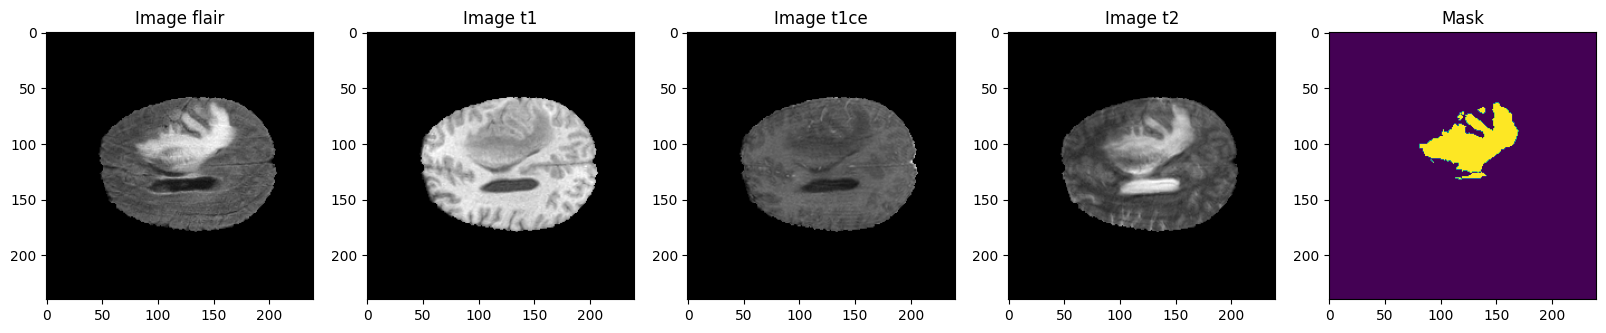

In [4]:
import nibabel as nib
from matplotlib import pyplot as plt
import os

test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
slice_number = test_image_flair.shape[0]//2-slice_w
ax1.imshow(test_image_flair[:,:,slice_number], cmap='gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,slice_number], cmap='gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,slice_number], cmap='gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,slice_number], cmap='gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,slice_number])
ax5.set_title('Mask')

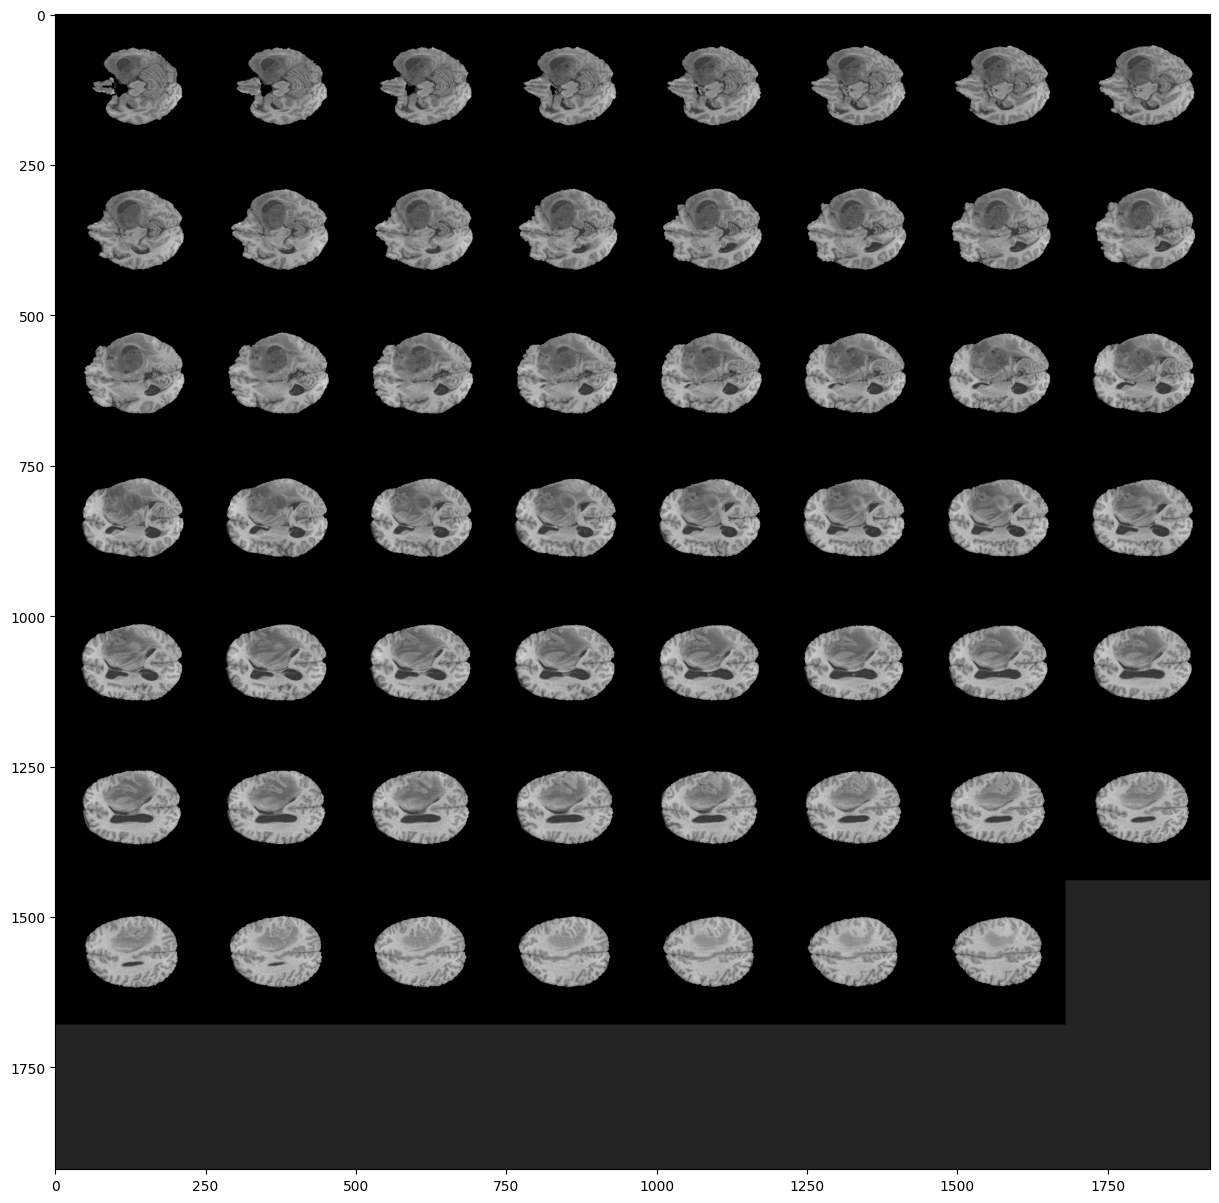

In [5]:
from skimage.util import montage
from skimage.transform import rotate
import numpy as np

# We can skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(montage(np.transpose(test_image_t1[..., 50:-50], (2, 0, 1))), cmap ='gray')

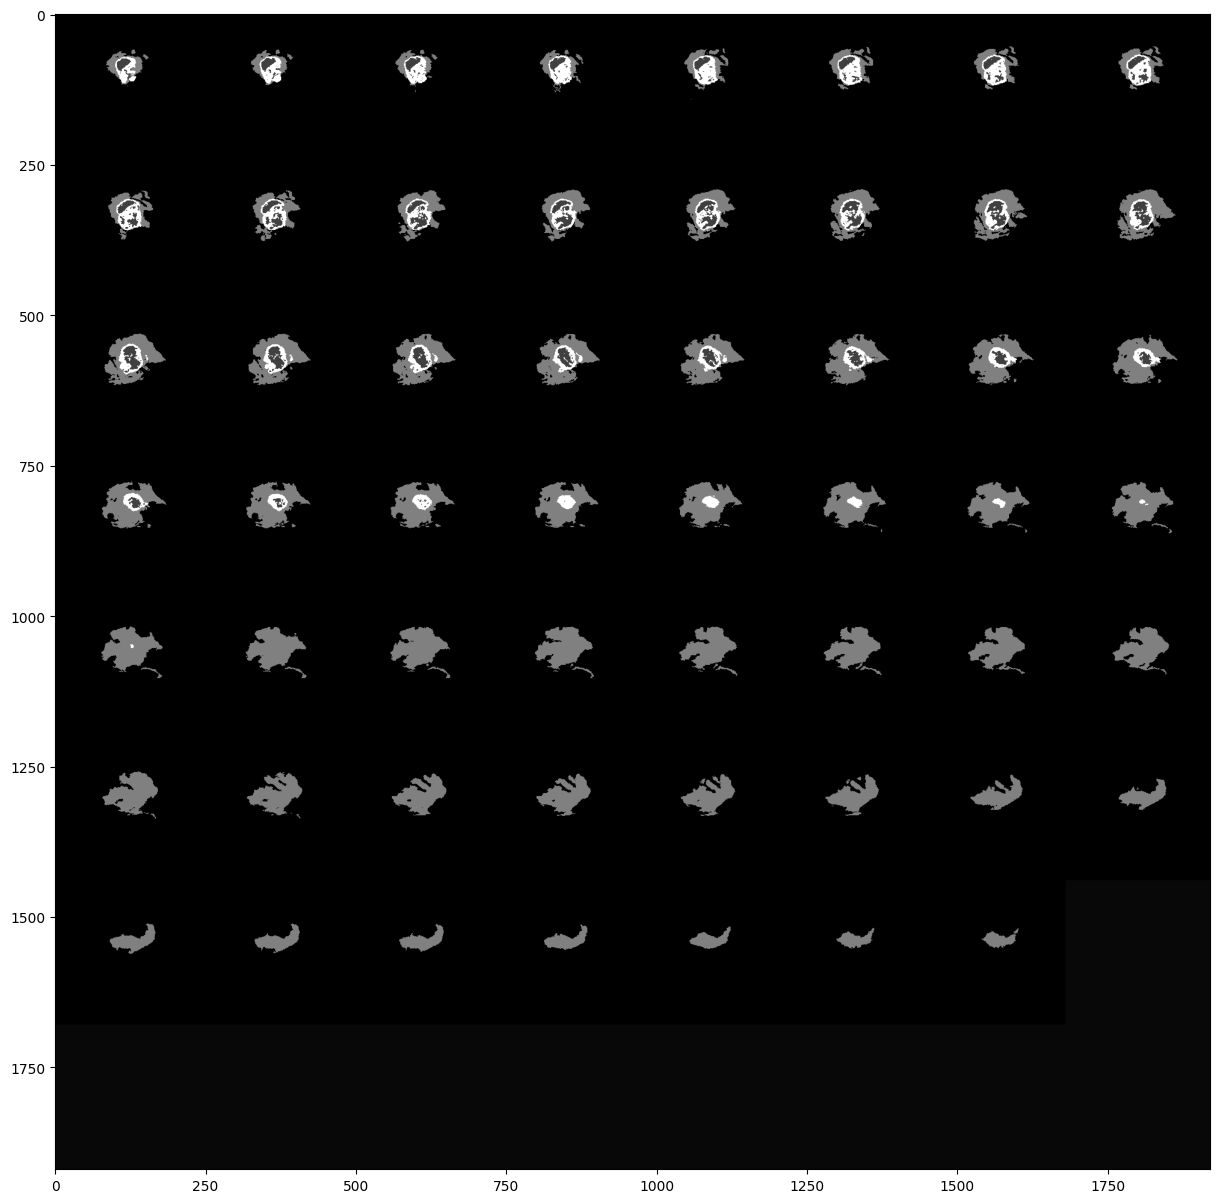

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(montage(np.transpose(test_mask[..., 50:-50], (2, 0, 1))), cmap ='gray')

In [7]:
import torch
import torch.nn as nn
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels, affine=False, track_running_stats=False),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels, affine=False, track_running_stats=False),
        nn.ReLU(inplace=True)
    )
    return conv_op

In [8]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, x):
        # TODO: Write here!
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        up_1 = self.up_transpose_1(down_9)
        up_2 = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_3 = self.up_transpose_2(up_2)
        up_4 = self.up_convolution_2(torch.cat([down_5, up_3], 1))
        up_5 = self.up_transpose_3(up_4)
        up_6 = self.up_convolution_3(torch.cat([down_3, up_5], 1))
        up_7 = self.up_transpose_4(up_6)
        up_8 = self.up_convolution_4(torch.cat([down_1, up_7], 1))

        out = self.out(up_8)

        return out

In [9]:
model = UNet(num_classes=1)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
model.to(device);

In [12]:
!pip install torchsummary

In [13]:
from torchsummary import summary

summary(model, (1, 240, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]             640
       BatchNorm2d-2         [-1, 64, 240, 240]               0
              ReLU-3         [-1, 64, 240, 240]               0
            Conv2d-4         [-1, 64, 240, 240]          36,928
       BatchNorm2d-5         [-1, 64, 240, 240]               0
              ReLU-6         [-1, 64, 240, 240]               0
         MaxPool2d-7         [-1, 64, 120, 120]               0
            Conv2d-8        [-1, 128, 120, 120]          73,856
       BatchNorm2d-9        [-1, 128, 120, 120]               0
             ReLU-10        [-1, 128, 120, 120]               0
           Conv2d-11        [-1, 128, 120, 120]         147,584
      BatchNorm2d-12        [-1, 128, 120, 120]               0
             ReLU-13        [-1, 128, 120, 120]               0
        MaxPool2d-14          [-1, 128,

In [14]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [15]:
from sklearn.model_selection import train_test_split
import os

# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.15)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

print(f"Train: {len(train_ids)} | Validation: {len(val_ids)} | Test: {len(test_ids)}")

Train: 265 | Validation: 56 | Test: 47


In [16]:
def load_dataset(ids, path):
    # TODO: Write here
    images = np.zeros((len(ids)*10, 240, 240), np.float32)
    masks = np.zeros((len(ids)*10, 240, 240), np.float32)

    i = 0
    for id in ids:
        t2 = nib.load(f"{path}{id}/{id}_t2.nii").get_fdata()
        seg = nib.load(f"{path}{id}/{id}_seg.nii").get_fdata()

        for s in range(50, seg.shape[2]-50, 10):
            images[i] = t2[:, :, s] / t2.max()
            masks[i] = seg[:, :, s] > 0
            i += 1

    images = np.expand_dims(images[:i], axis=1)
    masks = np.expand_dims(masks[:i], axis=1)

    return images, masks

train_images, train_masks = load_dataset(train_ids, TRAIN_DATASET_PATH)
val_images, val_masks = load_dataset(val_ids, TRAIN_DATASET_PATH)

In [17]:
train_images.shape, val_masks.shape

((1590, 1, 240, 240), (336, 1, 240, 240))

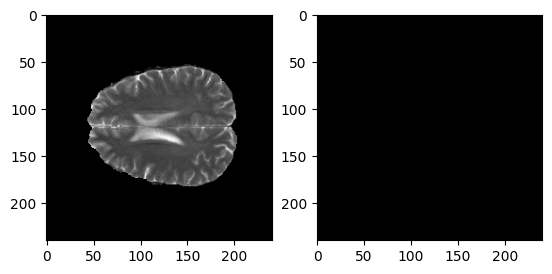

In [18]:
plt.subplot(121)
plt.imshow(train_images[100, 0], cmap='gray')
plt.subplot(122)
plt.imshow(train_masks[100, 0], cmap='gray')

In [19]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = TensorDataset(torch.from_numpy(train_images).type(torch.float32), torch.from_numpy(train_masks).type(torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(val_images).type(torch.float32), torch.from_numpy(val_masks).type(torch.float32))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

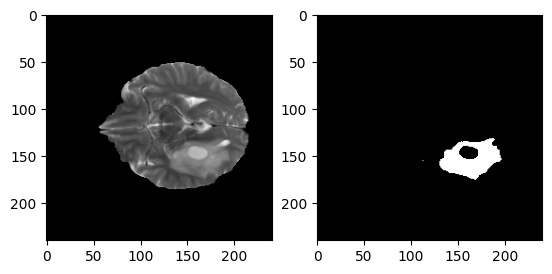

In [20]:
X, Y = next(iter(train_dataloader))
plt.subplot(121)
plt.imshow(X[0, 0], cmap='gray')
plt.subplot(122)
plt.imshow(Y[0, 0], cmap='gray')

In [21]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()# DiceLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 1 of 81
Train loss: 1.17692, Dice: 0.87032, BCE: 0.30659 | Test loss: 0.96926, Dice: 0.79161, BCE: 0.17766



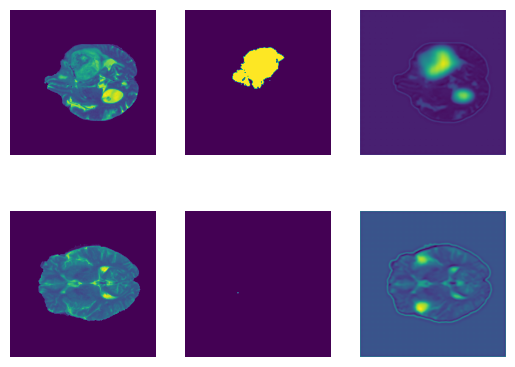

Epoch: 2 of 81
Train loss: 0.85820, Dice: 0.73024, BCE: 0.12796 | Test loss: 0.73114, Dice: 0.63515, BCE: 0.09600

Epoch: 3 of 81
Train loss: 0.63284, Dice: 0.55955, BCE: 0.07329 | Test loss: 0.53405, Dice: 0.47467, BCE: 0.05938

Epoch: 4 of 81
Train loss: 0.46920, Dice: 0.41731, BCE: 0.05190 | Test loss: 0.40110, Dice: 0.35245, BCE: 0.04865

Epoch: 5 of 81
Train loss: 0.38615, Dice: 0.34013, BCE: 0.04603 | Test loss: 0.35165, Dice: 0.30531, BCE: 0.04634

Epoch: 6 of 81
Train loss: 0.34798, Dice: 0.30442, BCE: 0.04356 | Test loss: 0.32398, Dice: 0.27847, BCE: 0.04551

Epoch: 7 of 81
Train loss: 0.30373, Dice: 0.26371, BCE: 0.04002 | Test loss: 0.31900, Dice: 0.26958, BCE: 0.04941

Epoch: 8 of 81
Train loss: 0.28882, Dice: 0.24965, BCE: 0.03917 | Test loss: 0.28296, Dice: 0.24073, BCE: 0.04223

Epoch: 9 of 81
Train loss: 0.26735, Dice: 0.22997, BCE: 0.03738 | Test loss: 0.30140, Dice: 0.25520, BCE: 0.04620

Epoch: 10 of 81
Train loss: 0.26535, Dice: 0.22826, BCE: 0.03709 | Test loss: 0.

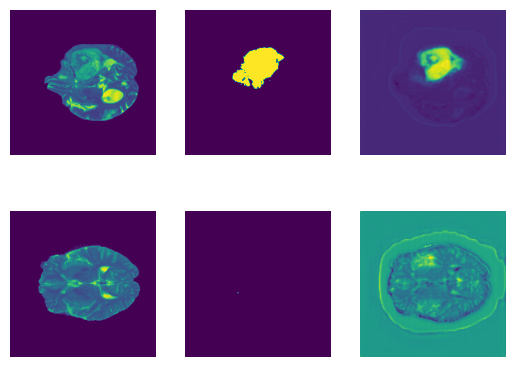

Epoch: 12 of 81
Train loss: 0.24276, Dice: 0.20791, BCE: 0.03486 | Test loss: 0.26979, Dice: 0.22701, BCE: 0.04278

Epoch: 13 of 81
Train loss: 0.24237, Dice: 0.20770, BCE: 0.03467 | Test loss: 0.25902, Dice: 0.21580, BCE: 0.04322

Epoch: 14 of 81
Train loss: 0.24004, Dice: 0.20460, BCE: 0.03544 | Test loss: 0.25695, Dice: 0.21410, BCE: 0.04285

Epoch: 15 of 81
Train loss: 0.22763, Dice: 0.19475, BCE: 0.03288 | Test loss: 0.23957, Dice: 0.19890, BCE: 0.04067

Epoch: 16 of 81
Train loss: 0.22526, Dice: 0.19199, BCE: 0.03327 | Test loss: 0.24909, Dice: 0.20606, BCE: 0.04303

Epoch: 17 of 81
Train loss: 0.22076, Dice: 0.18737, BCE: 0.03339 | Test loss: 0.23725, Dice: 0.19835, BCE: 0.03890

Epoch: 18 of 81
Train loss: 0.21350, Dice: 0.18128, BCE: 0.03222 | Test loss: 0.24400, Dice: 0.20253, BCE: 0.04147

Epoch: 19 of 81
Train loss: 0.21117, Dice: 0.17988, BCE: 0.03128 | Test loss: 0.23211, Dice: 0.19437, BCE: 0.03774

Epoch: 20 of 81
Train loss: 0.20507, Dice: 0.17379, BCE: 0.03128 | Test 

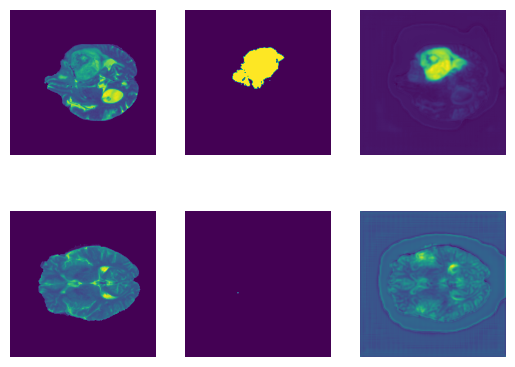

Epoch: 22 of 81
Train loss: 0.19650, Dice: 0.16672, BCE: 0.02977 | Test loss: 0.22477, Dice: 0.18692, BCE: 0.03785

Epoch: 23 of 81
Train loss: 0.18899, Dice: 0.16074, BCE: 0.02825 | Test loss: 0.23631, Dice: 0.19369, BCE: 0.04262

Epoch: 24 of 81
Train loss: 0.18978, Dice: 0.16065, BCE: 0.02913 | Test loss: 0.21631, Dice: 0.17988, BCE: 0.03644

Epoch: 25 of 81
Train loss: 0.18749, Dice: 0.15897, BCE: 0.02852 | Test loss: 0.21021, Dice: 0.17510, BCE: 0.03510

Epoch: 26 of 81
Train loss: 0.18083, Dice: 0.15288, BCE: 0.02795 | Test loss: 0.22228, Dice: 0.18362, BCE: 0.03866

Epoch: 27 of 81
Train loss: 0.17880, Dice: 0.15128, BCE: 0.02751 | Test loss: 0.22033, Dice: 0.18124, BCE: 0.03909

Epoch: 28 of 81
Train loss: 0.18025, Dice: 0.15247, BCE: 0.02778 | Test loss: 0.22413, Dice: 0.18143, BCE: 0.04270

Epoch: 29 of 81
Train loss: 0.17227, Dice: 0.14578, BCE: 0.02649 | Test loss: 0.21810, Dice: 0.17971, BCE: 0.03839

Epoch: 30 of 81
Train loss: 0.16671, Dice: 0.14107, BCE: 0.02563 | Test 

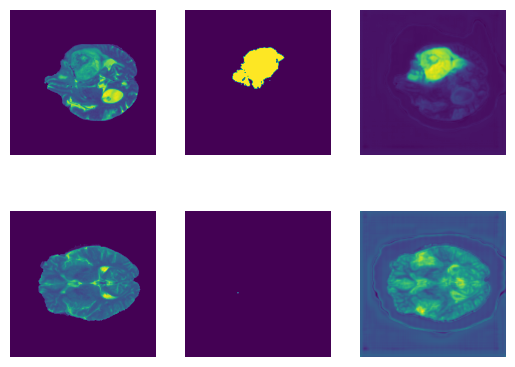

Epoch: 32 of 81
Train loss: 0.18223, Dice: 0.15402, BCE: 0.02821 | Test loss: 0.22103, Dice: 0.18266, BCE: 0.03837

Epoch: 33 of 81
Train loss: 0.17219, Dice: 0.14567, BCE: 0.02652 | Test loss: 0.20357, Dice: 0.16812, BCE: 0.03544

Epoch: 34 of 81
Train loss: 0.17369, Dice: 0.14680, BCE: 0.02689 | Test loss: 0.21536, Dice: 0.17483, BCE: 0.04054

Epoch: 35 of 81
Train loss: 0.16472, Dice: 0.13909, BCE: 0.02563 | Test loss: 0.21996, Dice: 0.18015, BCE: 0.03982

Epoch: 36 of 81
Train loss: 0.16874, Dice: 0.14250, BCE: 0.02624 | Test loss: 0.24265, Dice: 0.19774, BCE: 0.04491

Epoch: 37 of 81
Train loss: 0.16053, Dice: 0.13556, BCE: 0.02497 | Test loss: 0.20840, Dice: 0.17146, BCE: 0.03694

Epoch: 38 of 81
Train loss: 0.16101, Dice: 0.13598, BCE: 0.02503 | Test loss: 0.20635, Dice: 0.17083, BCE: 0.03552

Epoch: 39 of 81
Train loss: 0.16953, Dice: 0.14310, BCE: 0.02643 | Test loss: 0.23548, Dice: 0.19296, BCE: 0.04252

Epoch: 40 of 81
Train loss: 0.16028, Dice: 0.13522, BCE: 0.02506 | Test 

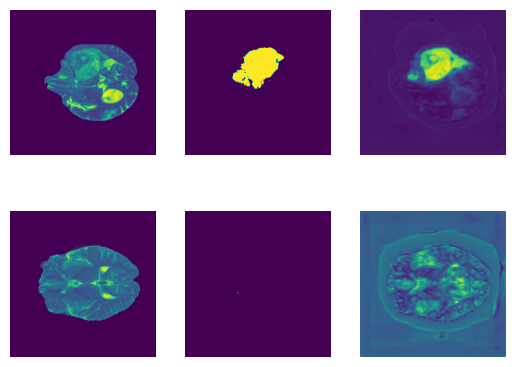

Epoch: 42 of 81
Train loss: 0.14599, Dice: 0.12322, BCE: 0.02277 | Test loss: 0.21354, Dice: 0.17510, BCE: 0.03844

Epoch: 43 of 81
Train loss: 0.14581, Dice: 0.12301, BCE: 0.02280 | Test loss: 0.22277, Dice: 0.18284, BCE: 0.03993

Epoch: 44 of 81
Train loss: 0.14195, Dice: 0.11999, BCE: 0.02197 | Test loss: 0.20326, Dice: 0.16527, BCE: 0.03799

Epoch: 45 of 81
Train loss: 0.14403, Dice: 0.12151, BCE: 0.02252 | Test loss: 0.19651, Dice: 0.16065, BCE: 0.03585

Epoch: 46 of 81
Train loss: 0.13814, Dice: 0.11650, BCE: 0.02164 | Test loss: 0.19964, Dice: 0.16485, BCE: 0.03479

Epoch: 47 of 81
Train loss: 0.14223, Dice: 0.12005, BCE: 0.02218 | Test loss: 0.19524, Dice: 0.15991, BCE: 0.03533

Epoch: 48 of 81
Train loss: 0.13333, Dice: 0.11274, BCE: 0.02060 | Test loss: 0.19962, Dice: 0.16255, BCE: 0.03707

Epoch: 49 of 81
Train loss: 0.13285, Dice: 0.11198, BCE: 0.02087 | Test loss: 0.19674, Dice: 0.16046, BCE: 0.03628

Epoch: 50 of 81
Train loss: 0.13667, Dice: 0.11535, BCE: 0.02133 | Test 

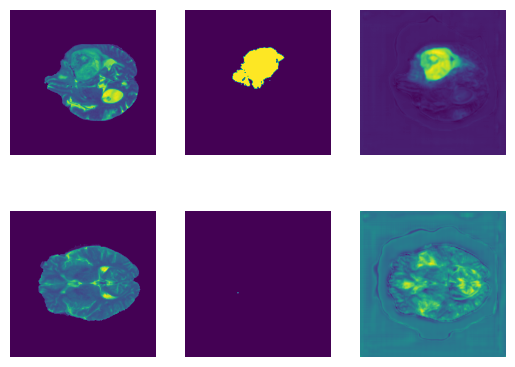

Epoch: 52 of 81
Train loss: 0.14844, Dice: 0.12521, BCE: 0.02324 | Test loss: 0.22890, Dice: 0.18415, BCE: 0.04476

Epoch: 53 of 81
Train loss: 0.14088, Dice: 0.11878, BCE: 0.02210 | Test loss: 0.19002, Dice: 0.15548, BCE: 0.03453

Epoch: 54 of 81
Train loss: 0.13542, Dice: 0.11413, BCE: 0.02129 | Test loss: 0.18907, Dice: 0.15511, BCE: 0.03396

Epoch: 55 of 81
Train loss: 0.13557, Dice: 0.11430, BCE: 0.02127 | Test loss: 0.19227, Dice: 0.15644, BCE: 0.03583

Epoch: 56 of 81
Train loss: 0.12386, Dice: 0.10420, BCE: 0.01965 | Test loss: 0.19867, Dice: 0.16117, BCE: 0.03750

Epoch: 57 of 81
Train loss: 0.13128, Dice: 0.11059, BCE: 0.02069 | Test loss: 0.19658, Dice: 0.16110, BCE: 0.03548

Epoch: 58 of 81
Train loss: 0.12833, Dice: 0.10788, BCE: 0.02044 | Test loss: 0.19234, Dice: 0.15719, BCE: 0.03514

Epoch: 59 of 81
Train loss: 0.12507, Dice: 0.10534, BCE: 0.01973 | Test loss: 0.18835, Dice: 0.15340, BCE: 0.03496

Epoch: 60 of 81
Train loss: 0.12211, Dice: 0.10284, BCE: 0.01927 | Test 

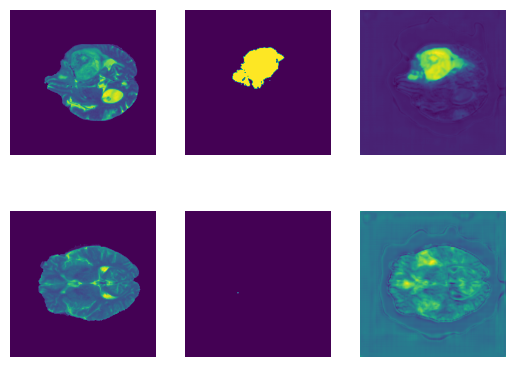

Epoch: 62 of 81
Train loss: 0.11947, Dice: 0.10029, BCE: 0.01918 | Test loss: 0.18427, Dice: 0.14948, BCE: 0.03479

Epoch: 63 of 81
Train loss: 0.11341, Dice: 0.09538, BCE: 0.01803 | Test loss: 0.18706, Dice: 0.15192, BCE: 0.03514

Epoch: 64 of 81
Train loss: 0.12273, Dice: 0.10320, BCE: 0.01953 | Test loss: 0.19310, Dice: 0.15793, BCE: 0.03518

Epoch: 65 of 81
Train loss: 0.11959, Dice: 0.10073, BCE: 0.01886 | Test loss: 0.19106, Dice: 0.15576, BCE: 0.03530

Epoch: 66 of 81
Train loss: 0.11895, Dice: 0.10006, BCE: 0.01889 | Test loss: 0.18623, Dice: 0.15111, BCE: 0.03511

Epoch: 67 of 81
Train loss: 0.13226, Dice: 0.11132, BCE: 0.02093 | Test loss: 0.17899, Dice: 0.14607, BCE: 0.03292

Epoch: 68 of 81
Train loss: 0.11176, Dice: 0.09408, BCE: 0.01768 | Test loss: 0.19032, Dice: 0.15385, BCE: 0.03648

Epoch: 69 of 81
Train loss: 0.11015, Dice: 0.09249, BCE: 0.01766 | Test loss: 0.20127, Dice: 0.16204, BCE: 0.03922

Epoch: 70 of 81
Train loss: 0.10852, Dice: 0.09124, BCE: 0.01728 | Test 

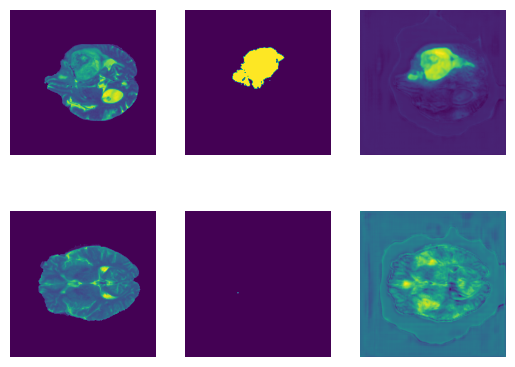

Epoch: 72 of 81
Train loss: 0.10525, Dice: 0.08846, BCE: 0.01679 | Test loss: 0.21822, Dice: 0.17338, BCE: 0.04484

Epoch: 73 of 81
Train loss: 0.10816, Dice: 0.09079, BCE: 0.01736 | Test loss: 0.20360, Dice: 0.16390, BCE: 0.03970

Epoch: 74 of 81
Train loss: 0.11304, Dice: 0.09516, BCE: 0.01788 | Test loss: 0.18722, Dice: 0.15150, BCE: 0.03572

Epoch: 75 of 81
Train loss: 0.10723, Dice: 0.09016, BCE: 0.01707 | Test loss: 0.19118, Dice: 0.15396, BCE: 0.03722

Epoch: 76 of 81
Train loss: 0.10796, Dice: 0.09074, BCE: 0.01721 | Test loss: 0.20634, Dice: 0.16501, BCE: 0.04133

Epoch: 77 of 81
Train loss: 0.10213, Dice: 0.08571, BCE: 0.01642 | Test loss: 0.21834, Dice: 0.17524, BCE: 0.04310

Epoch: 78 of 81
Train loss: 0.10454, Dice: 0.08817, BCE: 0.01637 | Test loss: 0.18401, Dice: 0.14847, BCE: 0.03554

Epoch: 79 of 81
Train loss: 0.09778, Dice: 0.08205, BCE: 0.01573 | Test loss: 0.18014, Dice: 0.14420, BCE: 0.03594

Epoch: 80 of 81
Train loss: 0.11922, Dice: 0.10040, BCE: 0.01881 | Test 

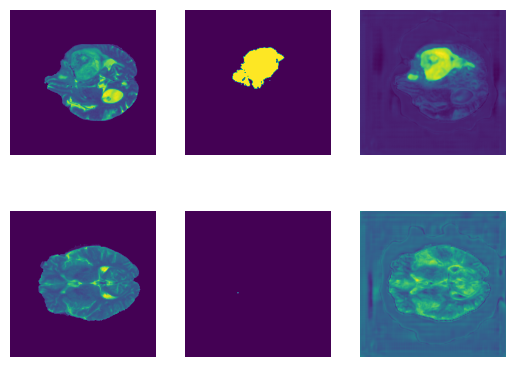

In [22]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Define model
model = UNet(num_classes=1).to(device)

# Setup loss function and optimizer
loss_fn_1 = DiceLoss()
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 81

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1} of {epochs}")
    ### Training
    train_loss_1, train_loss_2, train_loss = 0, 0, 0
    #
    model.train()
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        #
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2 Calculate loss (per batch)
        loss_1 = loss_fn_1(y_pred, y)
        loss_2 = loss_fn_2(y_pred, y)
        loss = loss_1 + loss_2
        train_loss += loss # accumulatively add up the loss per epoch)
        train_loss_1 += loss_1
        train_loss_2 += loss_2

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_loss_1 /= len(train_dataloader)
    train_loss_2 /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss_1, test_loss_2, test_loss = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            #
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss (accumatively)
            loss_1 = loss_fn_1(y_pred, y)
            loss_2 = loss_fn_2(y_pred, y)
            loss = loss_1 + loss_2
            test_loss += loss
            test_loss_1 += loss_1
            test_loss_2 += loss_2

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
        test_loss_1 /= len(test_dataloader)
        test_loss_2 /= len(test_dataloader)

    ## Print out what's happening
    print(f"Train loss: {train_loss:.5f}, Dice: {train_loss_1:.5f}, BCE: {train_loss_2:.5f} | Test loss: {test_loss:.5f}, Dice: {test_loss_1:.5f}, BCE: {test_loss_2:.5f}\n")
    
    if epoch % 10 == 0:
        plt.subplot(231)
        plt.imshow(X[0, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(232)
        plt.imshow(y[0, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(233)
        plt.imshow(y_pred[0, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(234)
        plt.imshow(X[12, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(235)
        plt.imshow(y[12, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(236)
        plt.imshow(y_pred[12, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.show()

In [23]:
torch.save(model.state_dict(), '/kaggle/working/unet_model.pth')

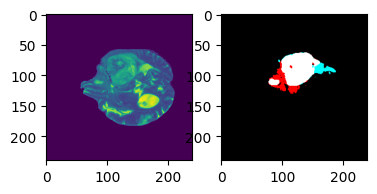

In [24]:
y1 = y[0, 0].cpu().detach().numpy()
y2 = y_pred[0, 0].cpu().detach().numpy()
y = np.zeros((*y1.shape, 3))
y[..., 0] = y1
y[..., 1] = y2
y[..., 2] = y2

plt.subplot(131)
plt.imshow(X[0, 0].cpu().detach().numpy())
plt.subplot(132)
plt.imshow(y)

In [25]:

def dice_score(preds, labels, smooth=1e-6):
    preds = preds.contiguous()
    labels = labels.contiguous()
    
    intersection = (preds * labels).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (preds.sum(dim=2).sum(dim=2) + labels.sum(dim=2).sum(dim=2) + smooth)
    
    return dice.mean().item()

all_dice_scores = []

with torch.no_grad():  # Gradients hesaplanmasın
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Veriyi cihaza taşı
        outputs = model(inputs)
        preds = (outputs > 0.5).float()  # Eşik değerini 0.5 olarak belirleyin
        dice = dice_score(preds, labels)
        all_dice_scores.append(dice)

avg_dice_score = sum(all_dice_scores) / len(all_dice_scores)
print(f'Average Dice Score: {avg_dice_score:.4f}')



Average Dice Score: 0.7713


In [26]:

def iou_score(preds, labels, smooth=1e-6):
    intersection = (preds * labels).sum((1, 2))  # Kesişim
    union = (preds + labels).clamp(0, 1).sum((1, 2))  # Birleşim
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

all_iou_scores = []

with torch.no_grad():  # Gradients hesaplanmasın
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Veriyi cihaza taşı
        outputs = model(inputs)
        preds_binary = (outputs > 0.5).float()  # Tahminleri ikili forma dönüştür
        labels_binary = (labels > 0.5).float()  # Etiketleri ikili forma dönüştür
        iou = iou_score(preds_binary, labels_binary)
        all_iou_scores.append(iou)

avg_iou_score = sum(all_iou_scores) / len(all_iou_scores)
print(f'Average IoU Score: {avg_iou_score:.4f}')


Average IoU Score: 0.9163


all_labels shape: (336, 240, 240)
all_probs shape: (336, 240, 240)


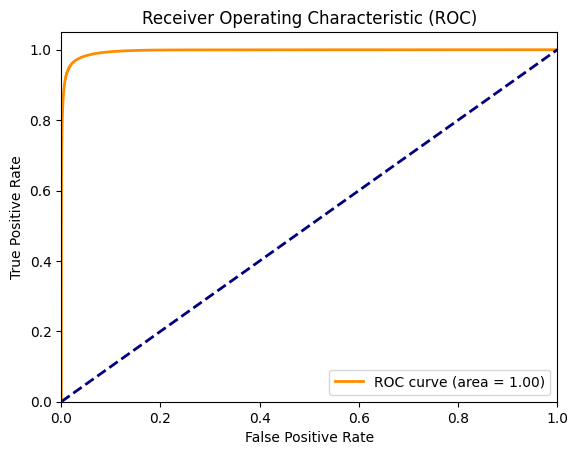

In [27]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# 3. Tahminlerin yapılması
all_labels = []
all_probs = []

with torch.no_grad():  # Gradients hesaplanmasın
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Veriyi cihaza taşı
        outputs = model(inputs)
        probs = outputs.squeeze()  # Tahmin olasılıkları
        all_probs.append(probs)
        all_labels.append(labels)

# GPU'daki tensorleri CPU'ya taşı ve numpy dizisine dönüştür
all_probs = torch.cat(all_probs, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
all_labels = all_labels.squeeze(1)

# Etiket ve tahmin edilen olasılıkların boyutlarını kontrol etme
print("all_labels shape:", all_labels.shape)
print("all_probs shape:", all_probs.shape)

# 4. ROC eğrisini çizme
fpr, tpr, thresholds = roc_curve(all_labels.ravel(), all_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [28]:
def calculate_metrics(y_true, y_pred):
    """
    Hesaplanacak metrikler için gerekli değerlerin hesaplanması.
    
    Argümanlar:
    y_true (torch.Tensor): Gerçek etiketler.
    y_pred (torch.Tensor): Tahmin edilen etiketler.
    
    Dönüş:
    dict: Hesaplanan metriklerin sözlük formatında dönüşü (accuracy, precision, recall, f1_score, specificity).
    """
    epsilon = 1e-7  # Sıfıra bölme hatası önlemek için küçük bir değer

    # TP, TN, FP, FN hesaplama
    TP = ((y_true == 1) & (y_pred == 1)).sum().item()
    TN = ((y_true == 0) & (y_pred == 0)).sum().item()
    FP = ((y_true == 0) & (y_pred == 1)).sum().item()
    FN = ((y_true == 1) & (y_pred == 0)).sum().item()

    # Metriklerin hesaplanması
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall + epsilon)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Metriklerin sözlük olarak dönüşü
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "specificity": specificity
    }

    return metrics


all_labels = []
all_preds = []


with torch.no_grad():  # Gradients hesaplanmasın
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Veriyi cihaza taşı
        outputs = model(inputs)
        preds_binary = (outputs > 0.5).float()  # Tahminleri ikili forma dönüştür
        labels_binary = (labels > 0.5).float()  # Etiketleri ikili forma dönüştür
        
        
        all_labels.append(labels_binary)
        all_preds.append(preds_binary)
        
# Tüm tahminleri ve etiketleri birleştir
all_labels = torch.cat(all_labels, dim=0)
all_preds = torch.cat(all_preds, dim=0)        
        
metrics = calculate_metrics(all_labels, all_preds)
print(metrics)

{'accuracy': 0.9929334594080688, 'precision': 0.8984470041537433, 'recall': 0.8192489576629264, 'f1_score': 0.857022133345139, 'specificity': 0.997542602927172}
